# SummPip: Unsupervised Multi-Document Summarization with Sentence Graph Compression

In [26]:
import numpy as np
import spacy
from scipy.spatial.distance import cosine, euclidean
from nltk.corpus import wordnet
import gensim.downloader as api
import nltk.data
import torch
from sklearn.cluster import SpectralClustering
import takahe
from rouge import FilesRouge
from prettytable import PrettyTable
import matplotlib.pyplot as plt

In [27]:
spacy_nlp = spacy.load("en_core_web_sm")

## Sentence Graph

In [28]:
glove_word_vectors = api.load("glove-wiki-gigaword-100")
discourse_markers=["for","so","because","since","therefore","consequently","additionally","furthermore","moreover",
         "but","however","although","despite","similarly","otherwise","whereas","while","unlike","thus",
        "instead","nevertheless","afterward","finally","subsequently","conversely","later","next","then",
         "likewise","compared","besides","further","as","also","equally","hence","accordingly","stil",
        "simultaneously"]
verbs_to_escape = ["be", "is","am","are","was", "were", "being","been","do","did",
               "done","have","had","get","got","gotten"]

In [29]:
class SentenceGraph:
    def __init__(self, sent_list, word2vec, thres_sim=0.9, thres=0.65):
        self.sent_list = sent_list
        self.sent_count = len(sent_list)
        self.word2vec = word2vec
        self.thres_sim = thres_sim
        self.thres = thres

    def get_sent_vector(self, sentence):
        sentence = sentence.lower()
        if len(sentence) > 0:
            sent_vector = [ self.word2vec.get(word, np.zeros(100)) for word in sentence.split()]
            sent_vector = np.mean(sent_vector, axis=0)
        else:
            sent_vector = np.zeros(100)

        return sent_vector + 1e-10

    def check_discourse_markers(self, sent1, sent2):
        isRelated = False
        tokenized_sent = spacy_nlp(sent2)
        if len(tokenized_sent) == 0: 
            return isRelated
        
        first_token = tokenized_sent[0].text.lower()
        if first_token in discourse_markers:
            isRelated = True

        return isRelated
    
    def get_noun_from_verb(self, verb):
        base_form = wordnet.morphy(verb, wordnet.VERB)
        noun_set = set()

        if base_form:
            lemmas = wordnet.lemmas(base_form, pos='v')
            for lemma in lemmas:
                for noun_form in lemma.derivationally_related_forms():
                    noun_set.add(noun_form.name())

        return list(noun_set)

    def check_deverbal_noun_reference(self, sent1, sent2):
        # get the nouns from the verbs of sentence 1
        token_sent1 = spacy_nlp(sent1)
        nouns_set = set()
        if len(token_sent1) > 0:
            for token in token_sent1:
                if token.pos_ == "VERB" and token.text not in verbs_to_escape:
                    noun_forms = self.get_noun_from_verb(token.text)
                    nouns_set.update(noun_forms)
        
        # get similar nouns
        similar_nouns = set()

        for noun in list(nouns_set):
            try:
                vect_similar = glove_word_vectors.most_similar(positive=[noun])
                for tup in vect_similar:
                    if tup[1] > self.thres:
                        similar_nouns.add(tup[0])
            except KeyError:
                pass

        similar_nouns = list(similar_nouns)

        # check if deverbal noun reference is present in next sentence
        isDeverbal = False
        token_sent2 = spacy_nlp(sent2)

        if len(token_sent2) > 0:
            for token in token_sent2:
                if token.pos_ == "NOUN" and token.text in similar_nouns:
                    isDeverbal = True
                    break

        return isDeverbal

    def check_entity_continuation(self, sent1, sent2):
        isEntity = False
        token_sent1 = spacy_nlp(sent1)
        token_sent2 = spacy_nlp(sent2)

        if len(token_sent1) > 0 and len(token_sent2) > 0:
            sent1_entities = [ (entity.text, entity.label_) for entity in token_sent1.ents]
            sent2_entities = [ (entity.text, entity.label_) for entity in token_sent2.ents]

            for entity in sent1_entities:
                if entity in sent2_entities:
                    isEntity = True
                    break

        return isEntity

    def check_sentence_similarity(self, sent1, sent2, dist='cosine'):
        isSimilar = False

        if dist == 'euclidean':
            similarity  = 1 / (1 + euclidean(sent1, sent2))
            if similarity > self.thres_sim:
                isSimilar = True
        else:
            cos_sim = 1 - cosine(sent1, sent2)
            if cos_sim > self.thres_sim:
                isSimilar = True
        
        return isSimilar
    
    def check_coreference(self, sent1, sent2):
        token_sent1 = spacy_nlp(sent1)
        token_sent2 = spacy_nlp(sent2)

        for token2 in token_sent2:
            if token2.pos_ == "PRON":
                for token1 in token_sent1:
                    if token1.pos_ == "NOUN" and token1.ent_id_ == token2.ent_id_:
                        return True
                    if token1.pos == "PRON" and token1.lemma_ == token2.lemma_ and token1.ent_id_ == token2.ent_id_:
                        return True
                    
        return False

    def create_sent_graph(self):
        # create adjacency matrix to represent edges between sentence nodes
        graph_mat = np.zeros((self.sent_count, self.sent_count))

        sent_vectors = []

        # calculate sentence embeddings for all the sentences
        for i in range(self.sent_count):
            sent_vect = self.get_sent_vector(self.sent_list[i])
            sent_vectors.append(sent_vect)

        # check for each pair of sentence nodes is they are related and should there be an edge between them
        for i in range(self.sent_count):
            for j in range(i+1, self.sent_count):
                isRelated = False

                if j == i+1:
                    isRelated = self.check_discourse_markers(self.sent_list[i], self.sent_list[j])

                    if not isRelated:
                        isRelated = self.check_deverbal_noun_reference(self.sent_list[i], self.sent_list[j])
                else:
                    isRelated = self.check_entity_continuation(self.sent_list[i], self.sent_list[j])

                if not isRelated:
                    isRelated = self.check_sentence_similarity(sent_vectors[i], sent_vectors[j])
            
                if isRelated:
                    graph_mat[i][j] = 1
                    graph_mat[j][i] = 1
        
        return graph_mat
    
    def create_sent_graph_exp(self, dist='cosine'):
        # create adjacency matrix to represent edges between sentence nodes
        graph_mat = np.zeros((self.sent_count, self.sent_count))

        sent_vectors = []

        # calculate sentence embeddings for all the sentences
        for i in range(self.sent_count):
            sent_vect = self.get_sent_vector(self.sent_list[i])
            sent_vectors.append(sent_vect)

        # check for each pair of sentence nodes is they are related and should there be an edge between them
        for i in range(self.sent_count):
            for j in range(i+1, self.sent_count):
                isRelated = False

                if j == i+1:
                    isRelated = self.check_discourse_markers(self.sent_list[i], self.sent_list[j])

                    if not isRelated:
                        isRelated = self.check_coreference(self.sent_list[i], self.sent_list[j])

                    if not isRelated:
                        isRelated = self.check_deverbal_noun_reference(self.sent_list[i], self.sent_list[j])
                
                if not isRelated:
                    isRelated = self.check_entity_continuation(self.sent_list[i], self.sent_list[j])

                if not isRelated:
                    isRelated = self.check_sentence_similarity(sent_vectors[i], sent_vectors[j], dist)
            
                if isRelated:
                    graph_mat[i][j] = 1
                    graph_mat[j][i] = 1
        
        return graph_mat

## SummPip Pipeline

The `takahe` module has been imported and used directly for the sentence compression.

In [30]:
class SumPip():
    def __init__(self, nb_clusters=12, nb_words=5, thres_sim=0.9, word2vec_file="word_vec/news_w2v.txt", seed=20):
        self.nb_clusters = nb_clusters
        self.nb_words = nb_words
        self.thres_sim = thres_sim
        self.word2vec = self.get_w2v_embeddings(word2vec_file)
        self.seed = seed

        torch.manual_seed(self.seed)
        torch.cuda.manual_seed(self.seed)

    def get_w2v_embeddings(self, word2vec_file):
        word_embeddings = {}

        with open(word2vec_file, encoding='utf-8') as file:
            for line in file:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                word_embeddings[word] = coefs

        return word_embeddings
    
    def spectral_clustering(self, adj_mat, sent_list):
        clustering = SpectralClustering(n_clusters = self.nb_clusters, random_state = self.seed).fit(adj_mat)
        sent_cluster = clustering.labels_

        num_clusters = max(sent_cluster)+1
        cluster_dict={new_list:[] for new_list in range(num_clusters)}\

		# group sentences by cluster ID
        for i, clusterID in enumerate(sent_cluster):
            cluster_dict[clusterID].append(sent_list[i])

        return cluster_dict 
    
    def tag_pos(self, str_text):
        doc=spacy_nlp(str_text)
        textlist=[]
        # compare the words between two strings
        for item in doc:
            source_token = item.text
            source_pos = item.tag_
            textlist.append(source_token+'/'+source_pos)
        return ' '.join(textlist)

    def get_tagged_sents(self, sent_list):
        tagged_list = []

        if len(sent_list) > 0:
            for s in sent_list:
                s = s.replace("/", "")
                temp_tagged = self.tag_pos(s)
                tagged_list.append(temp_tagged)
        else:
            tagged_list.append(self.tag_pos("."))

        return tagged_list

    # Using takahe module for sentence compression
    def get_compressed_sentence(self, sentences):
        compresser = takahe.word_graph(sentence_list = sentences, nb_words = self.nb_words, lang = 'en', punct_tag = "." )
        candidates = compresser.get_compression(3)
        reranker = takahe.keyphrase_reranker(sentences, candidates, lang = 'en')

        reranked_candidates = reranker.rerank_nbest_compressions()
        if len(reranked_candidates)>0:
            score, path = reranked_candidates[0]
            result = ' '.join([u[0] for u in path])
        else:
            result=' '
        return result

    def cluster_compression(self, cluster_dict):
        summary_list = []

        for sent_list in cluster_dict.values():
            tagged_sents = self.get_tagged_sents(sent_list)
            compressed_sent = self.get_compressed_sentence(tagged_sents)
            summary_list.append(compressed_sent)

        return " ".join(summary_list)
    
    def summarize(self, sent_list, exp=False, dist='cosine'):
        num_sent = len(sent_list)

        # Return the sentence list if the text is already shorter than the required summary
        if num_sent <= self.nb_clusters:
            summary = " ".join(sent_list)
            return summary
        
        # Create a adjacency matrix of sentence graph from the list of sentences
        sent_graph = SentenceGraph(sent_list, self.word2vec, self.thres_sim)
        if exp:
            adj_mat = sent_graph.create_sent_graph_exp(dist)
        else:
            adj_mat = sent_graph.create_sent_graph()

        # Perform Spectral Clustering on the sentence graph
        cluster_dict = self.spectral_clustering(adj_mat, sent_list)

        # Finally, applying cluster compression and extract summary
        summary = self.cluster_compression(cluster_dict)

        return summary



## Dataset Import

In [31]:
dataset_file = "dataset/original_text.txt"
word2vec_file = "word_vec/news_w2v.txt"
nb_words = 5
nb_clusters = 9
thres_sim = 0.9
seed = 20

Utilities

In [32]:
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

In [33]:
def read_file(file_path):
    with open(file_path, encoding='utf-8') as file:
        doc_list = []
        tag="story_separator_special_tag"
        for line in file:
            line = line.replace(tag, "")
            sent_list = sent_detector.tokenize(line.strip())
            doc_list.append(sent_list)
    
    return doc_list

Read Dataset File

In [34]:
doc_list = read_file(dataset_file)[:200]
print("Number of Documents:", len(doc_list))
print("Document 1:")
for sentence in doc_list[3]:
    print(sentence)

Number of Documents: 200
Document 1:
The seed for this crawl was a list of every host in the Wayback Machine This crawl was run at a level 1 ( URLs including their embeds , plus the URLs of all outbound links including their embeds ) The WARC files associated with this crawl are not currently available to the general public .
Summary : Microsoft 's acquisition of Nokia is aimed at building a devices and services strategy , but the joint company wo n't take the same form as Apple .
Microsoft has been working on its evolution into a devices and services company , away from the services business it has traditionally been , for several years now with limited success .
Its acquisition of most of Nokia is the latest acceleration of that strategy — to move further away from the moribund world of the beige desktop and towards the sunlit world of smartphones and tablets .
Owning the desktop ( via Windows ) and building additional services on top , like Office or search , has been vital for Micr

## Run the Original SumPip Module

In [35]:
summpip = SumPip(nb_clusters, nb_words, thres_sim, word2vec_file)

summary_list = []
for doc in doc_list:
    summary = summpip.summarize(doc)
    summary_list.append(summary)

C:\Users\Vivek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\Vivek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\Vivek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To 

In [36]:
print("Summary Document 1:")
for line in sent_detector.tokenize(summary_list[3]):
    print(line)

Summary Document 1:
he could stand on the platform 's edge .
summary : microsoft 's acquisition of nokia is aimed at building a devices and services strategy , but the joint company wo n't take the same form as apple .
nokia 's cell phone market share exceeded 35 % .
but it was blindsided by apple , then deprived of a chance to regain its footing by an even more aggressive google , which followed close behind .
whether this was the result hello there , there is a pertinent story about a man who was working on an oil platform in the north sea .
when he looked down over the edge , all he could see were the dark , cold , foreboding atlantic waters .
owning the desktop ( via windows ) and building additional services on top , like office or search , has been vital for microsoft 's strategy until now , so as our interest shifts from the desktop to the tablet or smartphone it 's essential to microsoft 's broader business ( even azure ) that it can retain that connection in some form .
micros

In [37]:
summary_list = [line.replace("\n","") +"\n" for line in summary_list]
output_file = "output/summary.txt"

with open(output_file, 'w', encoding='utf-8') as file:
    file.writelines(summary_list)

In [38]:
hyp_path = 'output/summary.txt'
ref_path = 'dataset/ref_summary.txt'
files_rouge = FilesRouge()
scores = files_rouge.get_scores(hyp_path, ref_path, avg=True)
origin_scores = [round(scores['rouge-1']['f'], 3), round(scores['rouge-2']['f'], 3), round(scores['rouge-l']['f'], 3)]

table = PrettyTable(['Model', 'Rouge-1', 'Rouge-2', 'Rouge-L'])
table.add_row(['Original'] + origin_scores)

print(table)


+----------+---------+---------+---------+
|  Model   | Rouge-1 | Rouge-2 | Rouge-L |
+----------+---------+---------+---------+
| Original |  0.377  |  0.136  |  0.329  |
+----------+---------+---------+---------+


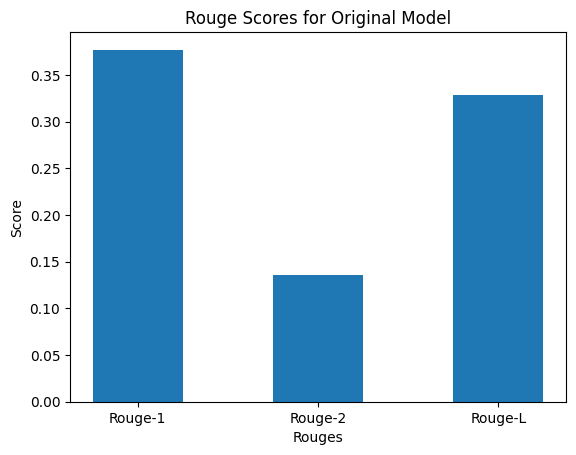

In [39]:
plt.bar(['Rouge-1', 'Rouge-2', 'Rouge-L'], origin_scores, width=0.5)
plt.title('Rouge Scores for Original Model')
plt.xlabel('Rouges')
plt.ylabel('Score')
plt.show()

## Run the SumPip with Experiments

### Experiment 1: Additional check for co-reference condition in sentence graph

In [40]:
summpip = SumPip(nb_clusters, nb_words, thres_sim, word2vec_file)

summary_list = []
for doc in doc_list:
    summary = summpip.summarize(doc, exp=True)
    summary_list.append(summary)

C:\Users\Vivek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\Vivek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\Vivek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To 

In [41]:
print("Summary Document 1:")
for line in sent_detector.tokenize(summary_list[3]):
    print(line)

Summary Document 1:
he could stand on the platform , and inevitably be consumed by the burning flames .
its acquisition of nokia is the latest acceleration of that strategy , but the joint company wo n't take the same form as apple .
nokia 's cell phone collapse has been a spectacular one .
microsoft has been working on its evolution into a devices and services company , away from the services business it has traditionally been , for several years now with limited success .
that same year , its phone business alone posted an operating profit of 5.48 billion euros .
the seed for this crawl was a list of every host in the wayback machine this crawl was run at a level 1 ( urls including their embeds , plus the urls of all outbound links including their embeds ) the warc files associated with this crawl are not currently available to the general public .
he woke up one night from a loud explosion , which suddenly set his entire oil platform on fire .
whether this was the result hello there

In [42]:
summary_list = [line.replace("\n","") +"\n" for line in summary_list]
output_file = "output/summary_exp.txt"

with open(output_file, 'w', encoding='utf-8') as file:
    file.writelines(summary_list)

In [43]:
hyp_path = 'output/summary_exp.txt'
ref_path = 'dataset/ref_summary.txt'
files_rouge = FilesRouge()
scores = files_rouge.get_scores(hyp_path, ref_path, avg=True)
exp1_scores = [round(scores['rouge-1']['f'], 3), round(scores['rouge-2']['f'], 3), round(scores['rouge-l']['f'], 3)]

table = PrettyTable(['Model', 'Rouge-1', 'Rouge-2', 'Rouge-L'])
table.add_row(['Original'] + origin_scores)
table.add_row(['Experiment-1'] + exp1_scores)

print(table)

+--------------+---------+---------+---------+
|    Model     | Rouge-1 | Rouge-2 | Rouge-L |
+--------------+---------+---------+---------+
|   Original   |  0.377  |  0.136  |  0.329  |
| Experiment-1 |   0.38  |  0.141  |  0.333  |
+--------------+---------+---------+---------+


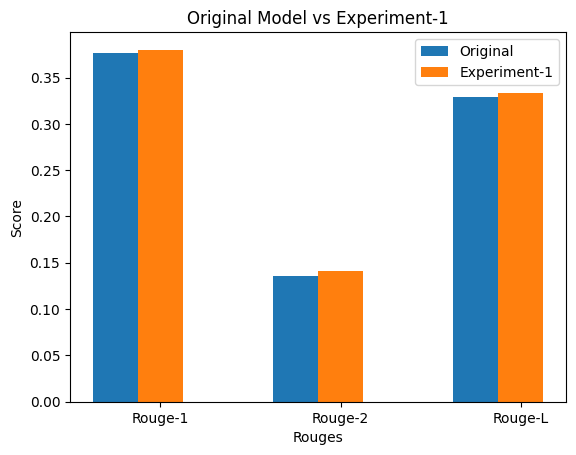

In [44]:
bar_width = 0.25
br1 = np.arange(len(origin_scores))
br2 = [x + bar_width for x in br1]

plt.bar(br1, origin_scores, width=bar_width, label='Original')
plt.bar(br2, exp1_scores, width=bar_width, label='Experiment-1')
plt.title('Original Model vs Experiment-1')
plt.xlabel('Rouges')
plt.ylabel('Score')
plt.xticks([r + bar_width for r in range(len(origin_scores))],
        ['Rouge-1', 'Rouge-2', 'Rouge-L'])
plt.legend()
plt.show()

### Experiment 2: Using Euclidean distance instead of Cosine similarity to check sentence similarity in Sentence Graph

In [45]:
summpip = SumPip(nb_clusters, nb_words, thres_sim, word2vec_file)

summary_list = []
for doc in doc_list:
    summary = summpip.summarize(doc, exp=True, dist='euclidean')
    summary_list.append(summary)

C:\Users\Vivek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\Vivek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\Vivek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To 

In [46]:
print("Summary Document 1:")
for line in sent_detector.tokenize(summary_list[3]):
    print(line)

Summary Document 1:
or , he could plunge 30 meters in to the freezing waters .
nokia 's cell phone collapse has been a spectacular one .
its acquisition of nokia is the latest acceleration of that strategy , but the joint company wo n't take the same form as apple .
the finnish giant dominated the dumbphone era after motorola , another faded star that recently fell into the hands of a comparative upstart .
owning the desktop ( via windows ) and building additional services on top , like office or search , has been vital for microsoft 's strategy until now with limited success .
he woke up one night from a loud explosion , which suddenly set his entire oil platform on fire .
whether this was the result hello there , there is a pertinent story about a man who was working on an oil platform in the north sea .
the man was standing upon a " burning platform , " and he needed to make a choice .
that same year , its phone business alone posted an operating profit of 5.48 billion euros .


In [47]:
summary_list = [line.replace("\n","") +"\n" for line in summary_list]
output_file = "output/summary_exp2.txt"

with open(output_file, 'w', encoding='utf-8') as file:
    file.writelines(summary_list)

In [48]:
hyp_path = 'output/summary_exp2.txt'
ref_path = 'dataset/ref_summary.txt'
files_rouge = FilesRouge()
scores = files_rouge.get_scores(hyp_path, ref_path, avg=True)
exp2_scores = [round(scores['rouge-1']['f'], 3), round(scores['rouge-2']['f'], 3), round(scores['rouge-l']['f'], 3)]

table = PrettyTable(['Model', 'Rouge-1', 'Rouge-2', 'Rouge-L'])
table.add_row(['Original'] + origin_scores)
table.add_row(['Experiment-2'] + exp2_scores)

print(table)

+--------------+---------+---------+---------+
|    Model     | Rouge-1 | Rouge-2 | Rouge-L |
+--------------+---------+---------+---------+
|   Original   |  0.377  |  0.136  |  0.329  |
| Experiment-2 |  0.373  |  0.135  |  0.328  |
+--------------+---------+---------+---------+


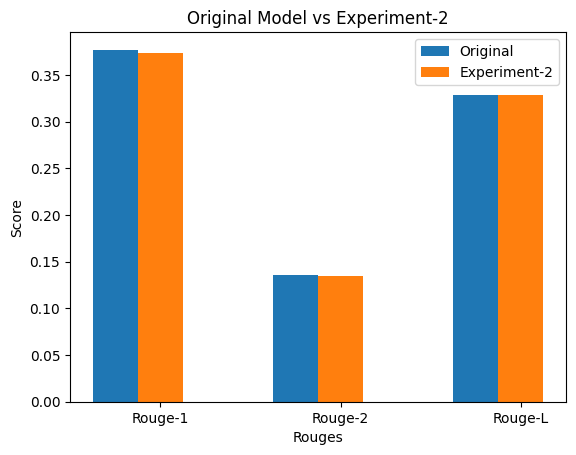

In [49]:
bar_width = 0.25
br1 = np.arange(len(origin_scores))
br2 = [x + bar_width for x in br1]

plt.bar(br1, origin_scores, width=bar_width, label='Original')
plt.bar(br2, exp2_scores, width=bar_width, label='Experiment-2')
plt.title('Original Model vs Experiment-2')
plt.xlabel('Rouges')
plt.ylabel('Score')
plt.xticks([r + bar_width for r in range(len(origin_scores))],
        ['Rouge-1', 'Rouge-2', 'Rouge-L'])
plt.legend()
plt.show()